In [1]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Pakete

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy.stats
#from scipy.stats import wilcoxon
import time
#import shap
import xgboost
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

#SVM
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance


# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint



# Tree Visualisation

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz



In [2]:

# testdaten für die presi holen
import os
os.getcwd()
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

df = pd.read_csv('data/aids0.csv', sep =",")

In [3]:
df.shape

(2139, 14)

In [4]:
df.columns

Index(['Unnamed: 0', 'trt', 'age', 'hemo', 'homo', 'drugs', 'z30', 'race',
       'gender', 'strat', 'symptom', 'cd40', 'cid', 'ecog'],
      dtype='object')

In [5]:
# für weitere Tables 'Unnamed' Nummerierung enfernen
df = df.drop(["Unnamed: 0"],axis=1) #,"hemo", "race", "ecog"

In [6]:
df.head(5)

,trt,age,hemo,homo,drugs,z30,race,gender,strat,symptom,cd40,cid,ecog
0,2,48,0,0,0,0,0,0,1,0,422,0,0
1,3,61,0,0,0,1,0,0,3,0,162,1,0
2,3,45,0,1,1,1,0,1,3,0,326,0,0
3,3,47,0,1,0,1,0,1,3,0,287,0,0
4,0,43,0,1,0,1,0,1,3,0,504,0,0


In [7]:
# one-hot-encoding
cat_columns=['trt', 'homo', 'drugs', 'z30', 'gender', 'strat', 'symptom','hemo', 'race', 'ecog'] #
df= pd.get_dummies(df, dtype=int, columns=cat_columns, drop_first=True)


## Datenspliting

In [8]:
X=df.drop(['cid'],axis=1)
y=df['cid']

In [9]:
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2,random_state=52)

print('X Train: {}'.format(X_train.shape)) 
print('Y Train: {}'.format(y_train.shape)) 
print('X Test: {}'.format(X_test.shape)) 
print('Y Test: {}'.format(y_test.shape))


X Train: (1711, 15)
Y Train: (1711,)
X Test: (428, 15)
Y Test: (428,)


### Vergleich Trainings- und Testdaten

Hier werden nur die zwei stetige Parameter vergliechen. Theoretisch können die nun encodeteten binären Features mittels Confusionsmatrix und Mann-Whitney-U vergliechen werden. Allerdings wird später im Verlauf die Accuranz für Trainings- und Testdaten vergliechen und so die Güte des Splitings geschätzt.

In [10]:
numset = df[['age', 'cd40']]


In [11]:
def calculate_mean(dataframe, feat):
        return np.mean(dataframe[feat].to_numpy())

for feature in numset.columns:
    print("Feature: {}, mean train: {}, mean test: {}".format(feature, calculate_mean(X_train, feature), calculate_mean(X_test, feature)))
    print("Feature: {}, Differenz: {}".format(feature, (calculate_mean(X_train, feature) - calculate_mean(X_test, feature)) ))

Feature: age, mean train: 35.27235534774985, mean test: 35.151869158878505
Feature: age, Differenz: 0.12048618887134666
Feature: cd40, mean train: 351.8205727644652, mean test: 345.2266355140187
Feature: cd40, Differenz: 6.5939372504465155


Es gibt eine minimale Differenz zwischen Test- und Trainingsdaten in bezug auf `CD-4`.

## Transformierung mit MinMaxScaler

Die Entscheidung für die Normalisierung (und nicht die Standardisierung) wurde in Anbetracht der Ungewissheit, wie die unbekannten, neuen Test-Daten verteilt werden würden, getroffen.

In [12]:
#from sklearn.preprocessing import MinMaxScaler
mscaler = MinMaxScaler()

X_train['age'] = mscaler.fit_transform(X_train['age'].to_numpy().reshape(-1,1))
X_train['cd40'] = mscaler.fit_transform(X_train['cd40'].to_numpy().reshape(-1,1))

X_test['age'] = mscaler.fit_transform(X_test['age'].to_numpy().reshape(-1,1))
X_test['cd40'] = mscaler.fit_transform(X_test['cd40'].to_numpy().reshape(-1,1))


In [13]:
def calculate_mean(dataframe, feat):
        return np.mean(dataframe[feat].to_numpy())
for feature in numset.columns:
    print("Feature: {}, mean train: {}, mean test: {}".format(feature, calculate_mean(X_train, feature), calculate_mean(X_test, feature)))


Feature: age, mean train: 0.40124750599568715, mean test: 0.4209430756159729
Feature: cd40, mean train: 0.29342833424892845, mean test: 0.4671537693017844


Ok. Die Differenz bei `CD-4` ist keiner geworden.

## Support Vector Machine


[Enscheidungsgrenzen für das SVC anzeichnen](https://scikit--learn-org.translate.goog/1.5/auto_examples/svm/plot_svm_kernels.html?_x_tr_sl=en&_x_tr_tl=de&_x_tr_hl=de&_x_tr_pto=rq#sphx-glr-auto-examples-svm-plot-svm-kernels-py) dienen der Visualisierung der grundsätzlichen Wirkung des Kernels auf Daten. 

In [14]:
#Create a svm Classifier


clf = svm.SVC(kernel='linear', C=2, probability=True, random_state=42) # Linear Kernel # RBF # Sigmoid # Tanh
clf.fit(X_train, y_train) #training

#Predict the response for test dataset
y_pred = clf.predict(X_test)

accu = metrics.accuracy_score(y_test, y_pred) # how often is the classifier correct?
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy Score: {}, Relevanz: {}, Sensitivität: {}".format(accu, precision,recall))


Accuracy Score: 0.7453271028037384, Relevanz: 0.0, Sensitivität: 0.0


In [15]:
#Accuracy im Traings- und Testdatensatz
# wie gut wurde getrennt? Der Unterschied ist nicht groß == guter Spliting

print("Accuracy Training: {}".format(clf.score(X_train, y_train)))
print("Accuracy Test: {}" .format(clf.score(X_test, y_test)))

Accuracy Training: 0.7592051431911163
Accuracy Test: 0.7453271028037384


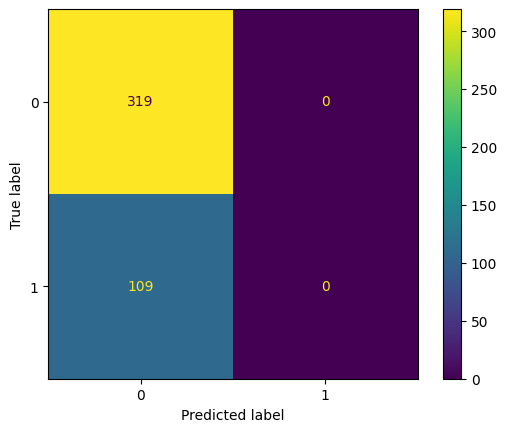

In [16]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot();

Wie kann das sein?

### 'RBF'

`C` ist ein Regulierungsparameter. [Doku](https://scikit--learn-org.translate.goog/1.5/auto_examples/svm/plot_svm_scale_c.html?_x_tr_sl=en&_x_tr_tl=de&_x_tr_hl=de&_x_tr_pto=rq#sphx-glr-auto-examples-svm-plot-svm-scale-c-py) dazu. Die Anpassung von `C` werde ich nach hinten anstellen müssen. 

Text(0.5, 0, 'Permutation Importance')

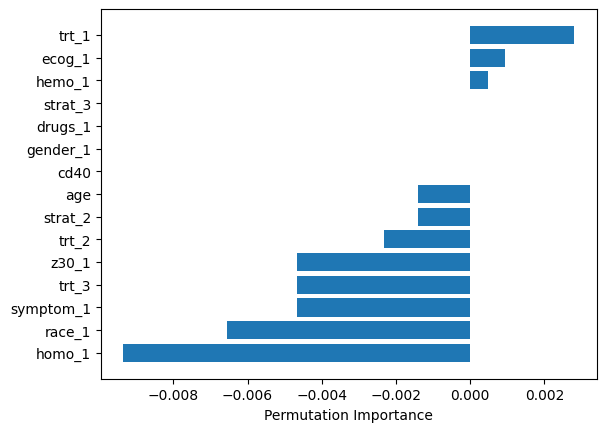

In [17]:
svc =  SVC(kernel='rbf', C=2, gamma='scale')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
perm_importance = permutation_importance(svc, X_test, y_test)

feature_names = X_train.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

#'permutation importance' gibt wieder, wie wichtig ein feature für das vorliegende Modell ist.

In [18]:
accu = metrics.accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Akkuranz: {}, Relevanz: {}, Sensitivität: {}".format(accu, precision,recall))

Akkuranz: 0.735981308411215, Relevanz: 0.25, Sensitivität: 0.01834862385321101


In [19]:
poli_kernel_svm_clf=make_pipeline(SVC(kernel='poly', degree=3, coef0=1, C=5))
poli_kernel_svm_clf.fit(X_train,y_train)
y_pred=poli_kernel_svm_clf.predict(X_test)

#from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) # how often is the classifier correct?



Accuracy: 0.735981308411215


## Random Forest

In [20]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.735981308411215


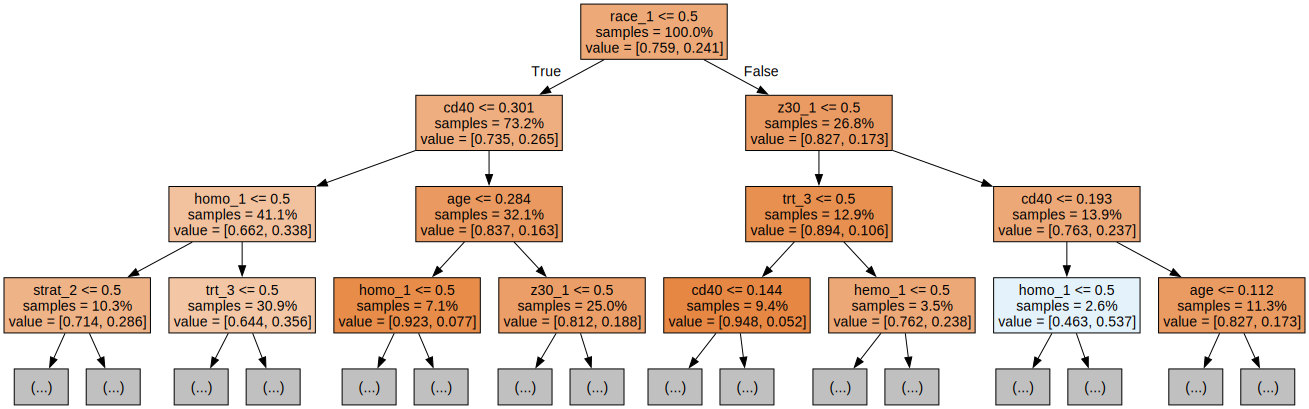

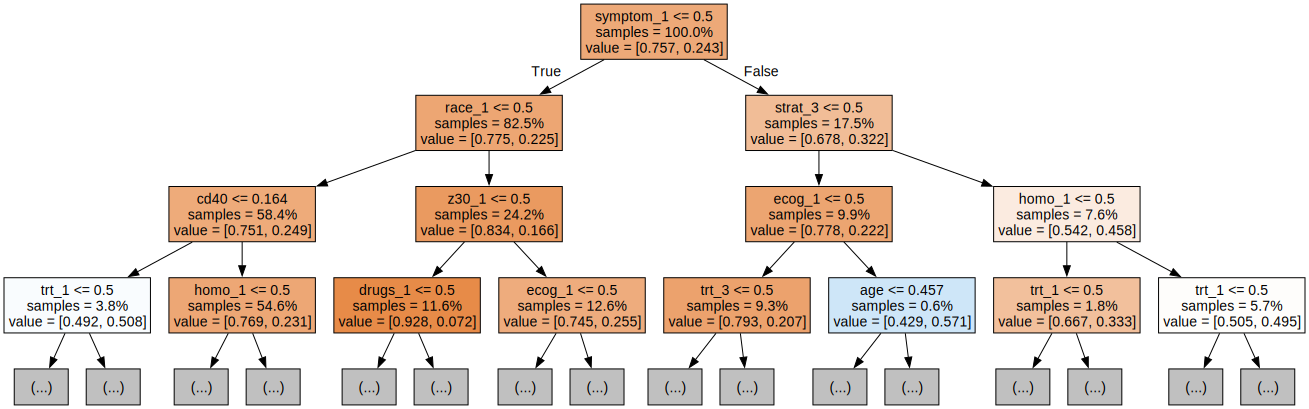

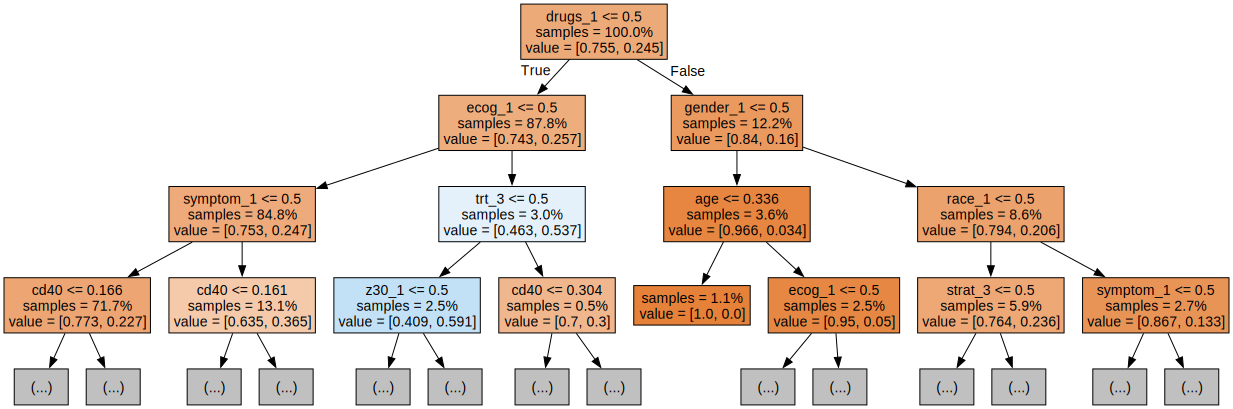

In [21]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=3, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [22]:
param_dist = {'n_estimators': randint(20,300),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002E55785B0A0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002E55781CF70>})

In [23]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 8, 'n_estimators': 31}


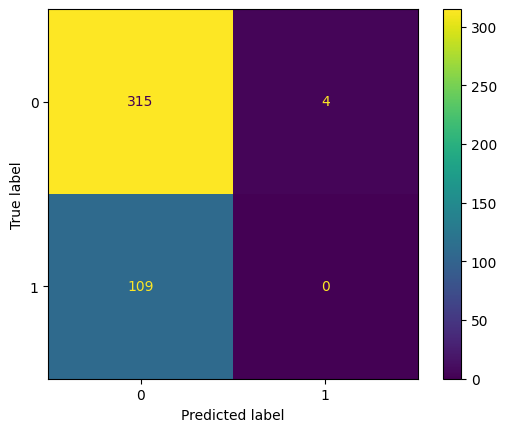

In [24]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [25]:
# probs mit knn.predict

y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.735981308411215
Precision: 0.0
Recall: 0.0


## Logistische Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
# training
logreg = LogisticRegression(random_state=42)
model = logreg.fit(X_train,y_train)

#prediction
y_pred = logreg.predict(X_test)

#evaluation
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy Score: {}, Relevanz: {}, Sensitivität: {}".format(str(logreg.score(X_test,y_test)), precision,recall))

Accuracy Score: 0.7476635514018691, Relevanz: 0.6, Sensitivität: 0.027522935779816515


Text(0.5, 0, 'Permutation Importance')

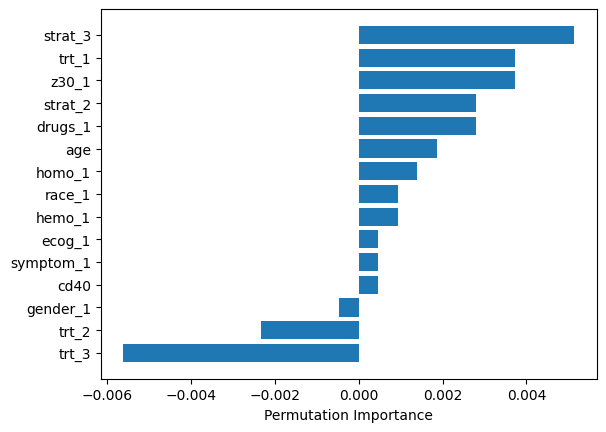

In [27]:
perm_importance = permutation_importance(logreg, X_test, y_test)

feature_names = X_train.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")


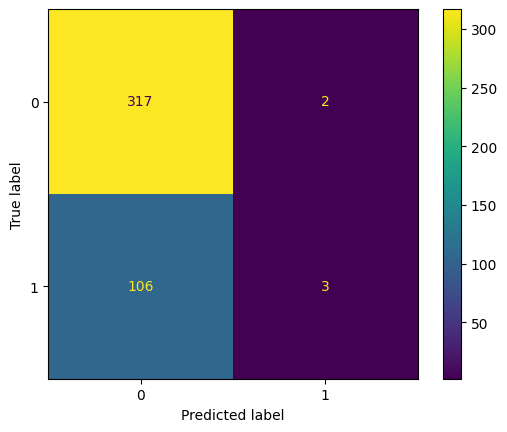

In [28]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm).plot();

## Evaluation

In [29]:

def acu(y_pred,y_test):
    return metrics.accuracy_score(y_test, y_pred)

def train_evaluate_time(method):
    start_time = time.time()
    methods[method].fit(X_train, y_train)
    running_time = round(time.time() - start_time,2)
    model_predict = methods[method].predict(X_test)
    model_acu = acu(model_predict,y_test)
    print("Genauigkeit von {}: {}; running time: {}".format(method, model_acu, running_time))


methods = {"Log Regression": LogisticRegression(), "svm": svm.SVC(), "Random Forest": RandomForestClassifier()}


for method in methods:
    train_evaluate_time(method)

Genauigkeit von Log Regression: 0.7476635514018691; running time: 0.02
Genauigkeit von svm: 0.7383177570093458; running time: 0.14
Genauigkeit von Random Forest: 0.7406542056074766; running time: 0.29


## Interpretation

### SVM

<Axes: >

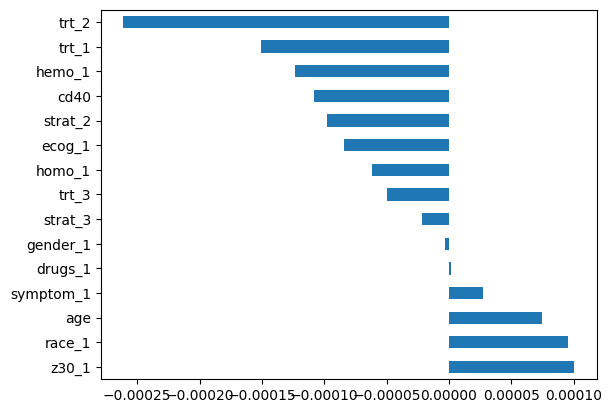

In [30]:

feature_names = X_train.columns
features = np.array(feature_names)

pd.Series((clf.coef_[0]), index=features).nlargest(15).plot(kind='barh') #abs(clf.coef_[0])

### Random Forest

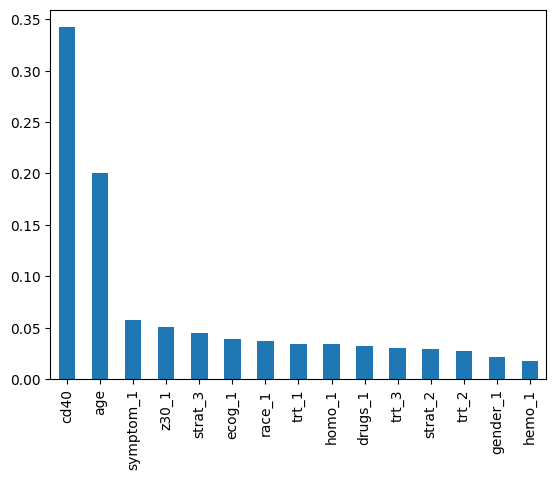

In [31]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

In [32]:
print(feature_importances)

cd40         0.342257
age          0.200436
symptom_1    0.057492
z30_1        0.050835
strat_3      0.045251
ecog_1       0.038578
race_1       0.037397
trt_1        0.034330
homo_1       0.034142
drugs_1      0.032008
trt_3        0.030652
strat_2      0.029234
trt_2        0.027623
gender_1     0.021996
hemo_1       0.017769
dtype: float64


### Logistische Regression

In [33]:
from sklearn.linear_model import LogisticRegression
m=LogisticRegression()
m.fit(X_train / np.std(X_train, 0), y_train)
print(m.coef_)

[[ 0.16127715 -0.47759685 -0.38094132 -0.35168011 -0.28451117  0.03745477
  -0.13956558  0.15973099  0.05020551  0.10015237  0.17838585  0.22603799
  -0.03630138 -0.06007568  0.08440313]]


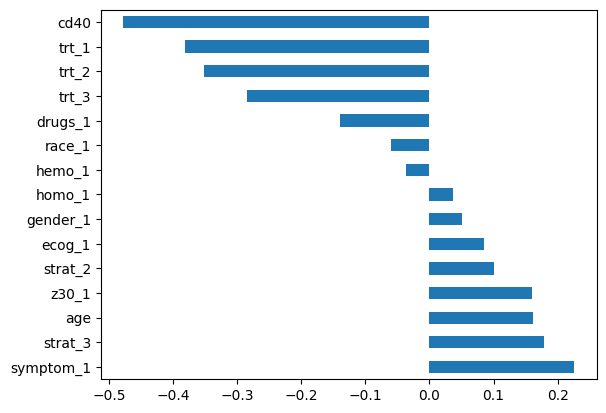

In [34]:
plot=pd.Series((m.coef_[0]), index=features).nlargest(15).plot(kind='barh')
plt.title="Feature Importance LogReg"

In [35]:

model_fi = permutation_importance(model, X_train, y_train)
fi=model_fi['importances_mean']
print(fi)

[ 0.00058445  0.00771479  0.00455874 -0.00035067  0.00035067 -0.00187025
 -0.00023378  0.00327294 -0.00070134  0.00093513  0.00292227  0.00303916
 -0.00105202  0.00035067  0.00058445]


In [36]:
X_train.columns

Index(['age', 'cd40', 'trt_1', 'trt_2', 'trt_3', 'homo_1', 'drugs_1', 'z30_1',
       'gender_1', 'strat_2', 'strat_3', 'symptom_1', 'hemo_1', 'race_1',
       'ecog_1'],
      dtype='object')

In [37]:
print(np.max(fi))

0.007714786674459373
